# Predicting location of Spike protein in SARS-CoV2 DNA  

Some fooling around trying to predict the spike protein location inside SARS-CoV2 DNA. Raw DNA will be transformed into Entropy values via [dnasr](https://github.com/Luk13Mad/dnasr), annotated with the spike protein location and then piped into a TF model.

In [105]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import random
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
print("all packages loaded")

all packages loaded


# Preparing sequences  
If you want to skip the data polishing and annotating jump straight to "Prepare data for TF" EDIT:File was to large for upload. 

In [81]:
fasta_file=os.path.join(os.getcwd(),"data","sequences.fasta") #file with DNA sequences
myrecords=[seq_record for seq_record in SeqIO.parse(fasta_file, "fasta")]
myrecords=list(filter(lambda x: 26000 < len(x) < 32000, myrecords)) #filter for full genomes
print(f"Number of SARS-Cov2 sequences in file: {len(myrecords)}")
SPIKE_PROTEIN=[seq_record for seq_record in SeqIO.parse(os.path.join(os.getcwd(),"data","spike_protein.fasta"), "fasta")][0]
#File with spike protein which will be our target we try to predict
print(f"Length of DNA coding for spike protein: {len(SPIKE_PROTEIN)}")

Number of SARS-Cov2 sequences in file: 2280
Length of DNA coding for spike protein: 3822


In [82]:
myrecords=list(filter(lambda x: x.seq.find(SPIKE_PROTEIN.seq)!= -1,myrecords)) 
#filter for records containing the spike protein with no mismatches
print(f"Number of SARS-Cov2 sequences containing spike protein with no mismatches: {len(myrecords)}")

Number of SARS-Cov2 sequences containing spike protein with no mismatches: 160


In [83]:
for rec in myrecords: #add SeqFeature with SPIKE_PROTEIN location to each record, we will try to predict the position fo the spike protein from the entropy values
    start=rec.seq.find(SPIKE_PROTEIN.seq)
    end=start+len(SPIKE_PROTEIN)
    rec.features.append(SeqFeature(location=FeatureLocation(start=start,end=end),type="SPIKE_PROTEIN"))

In [13]:
SeqIO.write(random.sample(myrecords,50),os.path.join(os.getcwd(),"data","processed_seq.fasta"), "fasta")
#write 50 records to file
#only 50 so i can still load output from dnasr into RAM

50

# Calling DNASR 

Now call dnasr. Instructions how to install here https://github.com/Luk13Mad/dnasr .
Switch cell below to "CODE" and run it see how command looks like.

inp=os.path.join(os.getcwd(),"data","processed_seq.fasta")  
outp=os.path.join(os.getcwd(),"data")  
print(f"dnasr generate --db false -i {inp}  -o {outp} --ee true")  

# Loading and annotating entropy data

In [2]:
mydf=pd.read_csv(os.path.join(os.getcwd(),"data","dnasr_early_exit.txt"),sep="\t",header=None,names=["ID","window","kmer","E"])
#load output form dnasr

In [7]:
mydf.sort_values(by=["ID","window","kmer"],inplace=True)
mydf.reset_index(drop=True,inplace=True)
mydf.loc[mydf.E.isna(),"E"]=0

In [11]:
mydf["isSpike"]=0 #add column indicating whether position is inside spike
mydf.head()

,ID,window,kmer,E,isSpike
94838586,MW375727.1,29655,TGT,0.901785,0
94838587,MW375727.1,29655,TTA,0.997746,0
94838588,MW375727.1,29655,TTC,1.000000,0
94838589,MW375727.1,29655,TTG,1.000000,0
94838590,MW375727.1,29655,TTT,0.000000,0


In [16]:
for rec in myrecords:
    if mydf.ID.isin([str(rec.id)]).any():
        mask1=mydf.loc[:,"window"].isin(range(int(rec.features[0].location.start),int(rec.features[0].location.end)))
        mask2=mydf["ID"]==rec.id
        mydf.loc[pd.concat([mask1,mask2],axis=1).all(axis=1),"isSpike"]=1 #change "isSpike" column to 1 if spike present

print("done")

done


In [17]:
#mydf.to_csv(os.path.join(os.getcwd(),"data","finished_data.csv.gz"),sep="\t",compression="gzip",index=False)

# Prepare data for TF

In [2]:
mydf=pd.read_csv(os.path.join(os.getcwd(),"data","finished_data.csv.gz"),sep="\t",compression="gzip")

In [3]:
shapes=[] #get max length for later padding
for ID,inner_df in mydf.groupby(by=["ID"]):
    shapes.append(inner_df.shape)

In [4]:
max_len=max([x[0] for x in shapes])

def make_dict(): #make dict to feed into Dataset.from_tensor_slices
    mydict={"ID":[],"E":[],"isSpike":[]}
    for ID,inner_df in mydf.groupby(by=["ID"]):
        mydict["ID"].append(ID)
        #padding with 0
        mydict["E"].append( np.pad(np.array(inner_df.E),(0,max_len-inner_df.shape[0]), 'constant', constant_values=0).reshape((-1,64)) )
        mydict["isSpike"].append( np.array(inner_df.groupby("window").mean().isSpike) ) #each window gets 1 spike value
    _max_window=max([len(x) for x in mydict["isSpike"]])
    for idx,i in enumerate(mydict["isSpike"]):
        len_before=len(i)
        mydict["isSpike"][idx]=np.pad(i,(0,_max_window-len_before), 'constant', constant_values=0)
    return mydict,_max_window
mydict,max_window=make_dict()

In [5]:
tf_dataset=tf.data.Dataset.from_tensor_slices(mydict)

In [6]:
train_size = int(0.8 * tf_dataset.cardinality().numpy()) #split dataset into train and test
test_size = int(0.2 * tf_dataset.cardinality().numpy())

tf_dataset = tf_dataset.shuffle(60)
train_dataset = tf_dataset.take(train_size)
test_dataset = tf_dataset.skip(train_size)

# Set up Model

In [7]:
train_labels=train_dataset.map(lambda d : d["ID"])
train_feature=train_dataset.map(lambda d : d["E"])
train_target=train_dataset.map(lambda d : d["isSpike"])

test_labels=test_dataset.map(lambda d : d["ID"])
test_feature=test_dataset.map(lambda d : d["E"])
test_target=test_dataset.map(lambda d : d["isSpike"])

In [27]:
inputs=keras.Input(shape=(int(max_len/64),64))
x=layers.Flatten()(inputs)
x=layers.Dense(128, activation="relu")(x)
x=layers.Dense(64, activation="relu")(x)
outputs=layers.Dense(max_window,activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs, name="spike_predictor")
model.summary()

Model: "spike_predictor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 29753, 64)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1904192)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               243736704 
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 29753)             1933945   
Total params: 245,678,905
Trainable params: 245,678,905
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)

history = model.fit(tf.data.Dataset.zip((train_feature,train_target)).batch(10),epochs=3)


Epoch 1/3
4/4 [==============================] - 19s 2s/step - loss: 3.2114 - accuracy: 0.0000e+00
Epoch 2/3
4/4 [==============================] - 10s 1s/step - loss: 0.6399 - accuracy: 0.0000e+00
Epoch 3/3
4/4 [==============================] - 9s 1s/step - loss: 0.0151 - accuracy: 0.0000e+00


In [29]:
predictions=model.predict(test_feature.batch(1))
#np.save(os.path.join(os.getcwd(),"data","predictions.npy"),predictions)

# Let's plot our predictions

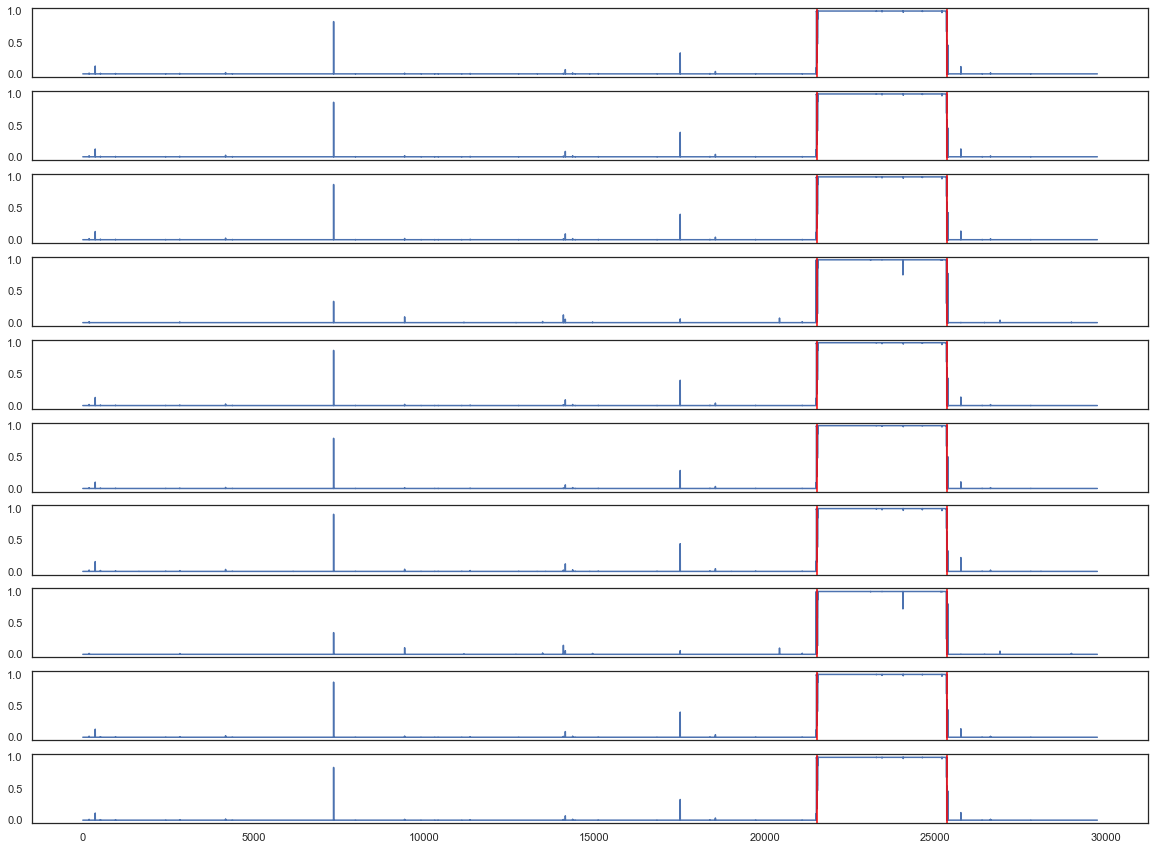

In [113]:
#predictions=np.load(os.path.join(os.getcwd(),"data","predictions.npy"))
average_start=np.mean([int(rec.features[0].location.start) for rec in myrecords])
average_end=np.mean([int(rec.features[0].location.end) for rec in myrecords])
fig, axs = plt.subplots(10,sharex=True,figsize=(20,15))
for i in range(10):
    axs[i].plot(np.arange(len(predictions[i])),predictions[i])
    axs[i].axvline(average_start,color="red")
    axs[i].axvline(average_end,color="red")

Each plot is one of our test cases. The red lines in each plot are average start and end points of the Spike.   

There is some noise but overall the predictions are pretty good.  

Obviously the model isn't specifically tailored for this task nor is the dataset large. I just wanted to practice with Tensorflow and have some fun with the information entropy.